# Figure 8 (methods figure): illustration of differences/ updates for C-SALE relative to classic ALE


#### Author: Neville Magielse
#### Date: 04.09.2024

In [1]:
import nimare
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import seaborn as sns
import nilearn.plotting, nilearn.maskers
from nilearn.plotting import plot_stat_map
import nibabel
from pprint import pprint
import sys
from nimare.meta.cbma.ale import ALE, SCALE
from nimare_gpu.ale import DeviceALE, DeviceSCALE
from nimare.correct import FWECorrector
import argparse
from numba import cuda
import json

from matplotlib.colors import ListedColormap

import SUITPy.flatmap
from tqdm import tqdm
from itertools import cycle


# User-specified base working directory
BASE_DIR = '/data/project/cerebellum_ale/'  # Change this to your project folder. Make sure they have input and output folders.

# Defines input and output paths.
INPUT_DIR = os.path.join(BASE_DIR, 'input')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')

sys.path.append(os.path.join(BASE_DIR, 'scripts'))
from utils import get_null_xyz

plt.rcParams.update({'font.size': 16, "font.family": "Asana Math", "figure.dpi": 192})

In [2]:
dset = nimare.dataset.Dataset.load(os.path.join(OUTPUT_DIR, 'data/Cognition/Cognition.Memory.Working/dset.pkl.gz'))

In [3]:
dset

Dataset(113 experiments, space='mni152_2mm')

In [4]:
MASK_NAME = 'D2009_MNI' # created via utils.create_Driedrischen2009_mask('MNI')
mask_img = nibabel.load(os.path.join(INPUT_DIR, 'maps', f'{MASK_NAME}.nii.gz'))
mask = nilearn.maskers.NiftiMasker(mask_img)
PROB_MAP_PATH = os.path.join(OUTPUT_DIR, 'BrainMap_dump_Feb2024_kernels_sum.nii.gz')

In [5]:
# Create the C-SALE results, note that thi uses GPU nodes.

In [45]:
prob_map = nibabel.load(PROB_MAP_PATH)
n_iters = 10000
sale = DeviceSCALE(
    'probabilistic',
    prob_map=prob_map,
    xyz=None,
    mask=mask, 
    n_iters=n_iters,
    nbits=64,
    keep_perm_nulls=True,
    keep_voxel_hists=True,
    sigma_scale=1.0,
    use_mmap=False,
    batch_size=10,
)

sale_res = sale.fit(dset)

ERROR:nimare_gpu.ale:_fit failed, removing /tmp/DeviceSCALEjgq6_5rb20240916T105734
ERROR:nimare_gpu.ale:_fit failed, removing /tmp/DeviceSCALE52mecpv720240916T105734


CUDARuntimeError: cudaErrorNoDevice: no CUDA-capable device is detected

## Get the study ids for the experiments we want to illustrate for the figure.

In [6]:
# Get the 1st, 2nd, 3rd, and last study id.
study_ids = dset.ids

# Find unique study IDs
unique_study_ids = np.unique(study_ids)

# Check the number of unique study IDs
num_unique_study_ids = len(unique_study_ids)
print(f"Number of unique study IDs: {num_unique_study_ids}")

# Define indices for first, second, third, and last study IDs
indices = [0, 1, len(dset.ids) - 1]

# Retrieve specific study IDs
selected_study_ids = [unique_study_ids[i] for i in indices]
print(f"Selected study IDs: {selected_study_ids}")


Number of unique study IDs: 113
Selected study IDs: ['10030050-0', '10030065-0', '9090132-0']


## We will start with ALE map calculation for the Working Memory subdomain. Note that in these steps, C-SALE is completely identical to classic ALE.
## First, let's display the distribution of foci in the Working Memory dataset.

In [7]:
null_xyz = get_null_xyz(dset, mask_path= os.path.join(INPUT_DIR, 'maps', f'{MASK_NAME}.nii.gz'))

In [8]:
null_xyz # coordinates for the working memory subdomain

array([[  0., -52., -36.],
       [-32., -56., -30.],
       [ 29., -52., -26.],
       ...,
       [-28., -60., -32.],
       [ 34., -62., -32.],
       [  0., -70., -12.]])

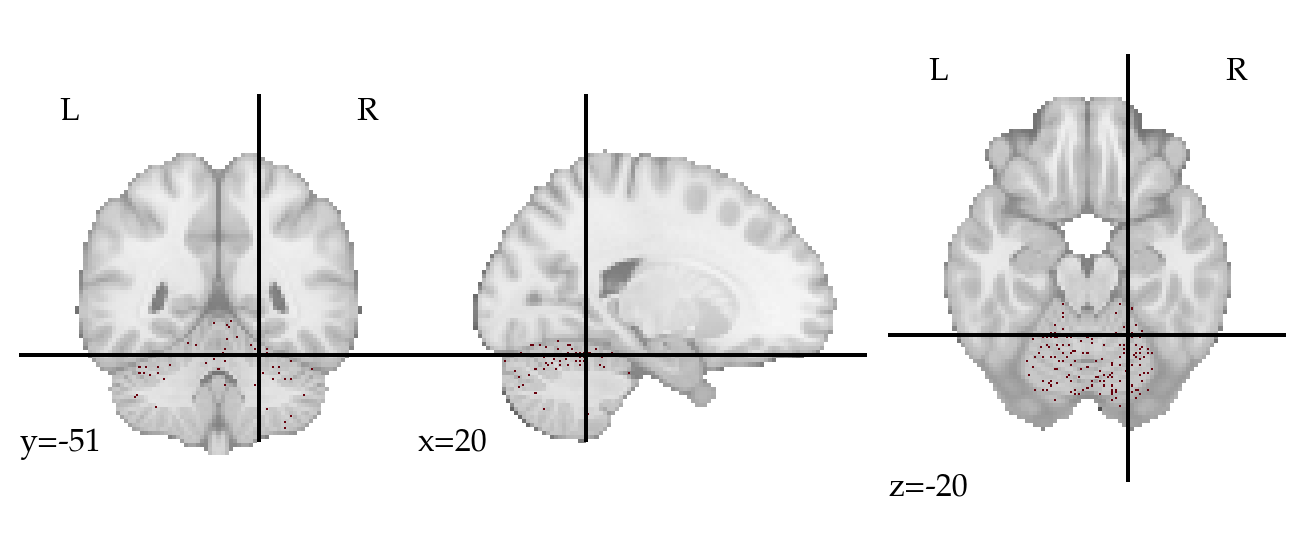

In [9]:
mni_temp = nilearn.datasets.load_mni152_template(resolution=1)
null_ijk = nibabel.affines.apply_affine(np.linalg.inv(mni_temp.affine), null_xyz).astype('int')
foci_img_data = np.zeros(mni_temp.shape)
foci_img_data[null_ijk[:,0], null_ijk[:, 1], null_ijk[:, 2]] = 1
foci_img = nilearn.image.new_img_like(mni_temp, foci_img_data)

fig = plt.figure(figsize=(10, 3))

nilearn.plotting.plot_stat_map(
    foci_img, 
    threshold=0, display_mode='ortho',
    cmap='Reds',
    colorbar=False
)

# Save the figure to a file
#output_path = os.path.join(BASE_DIR, 'Figures/Publication/Figure8/WorkingMemory_foci_distribution_ortho.png')
#plt.gcf().savefig(output_path, bbox_inches='tight', transparent=True)

# Close the display to avoid displaying it in interactive environments
plt.close(fig)

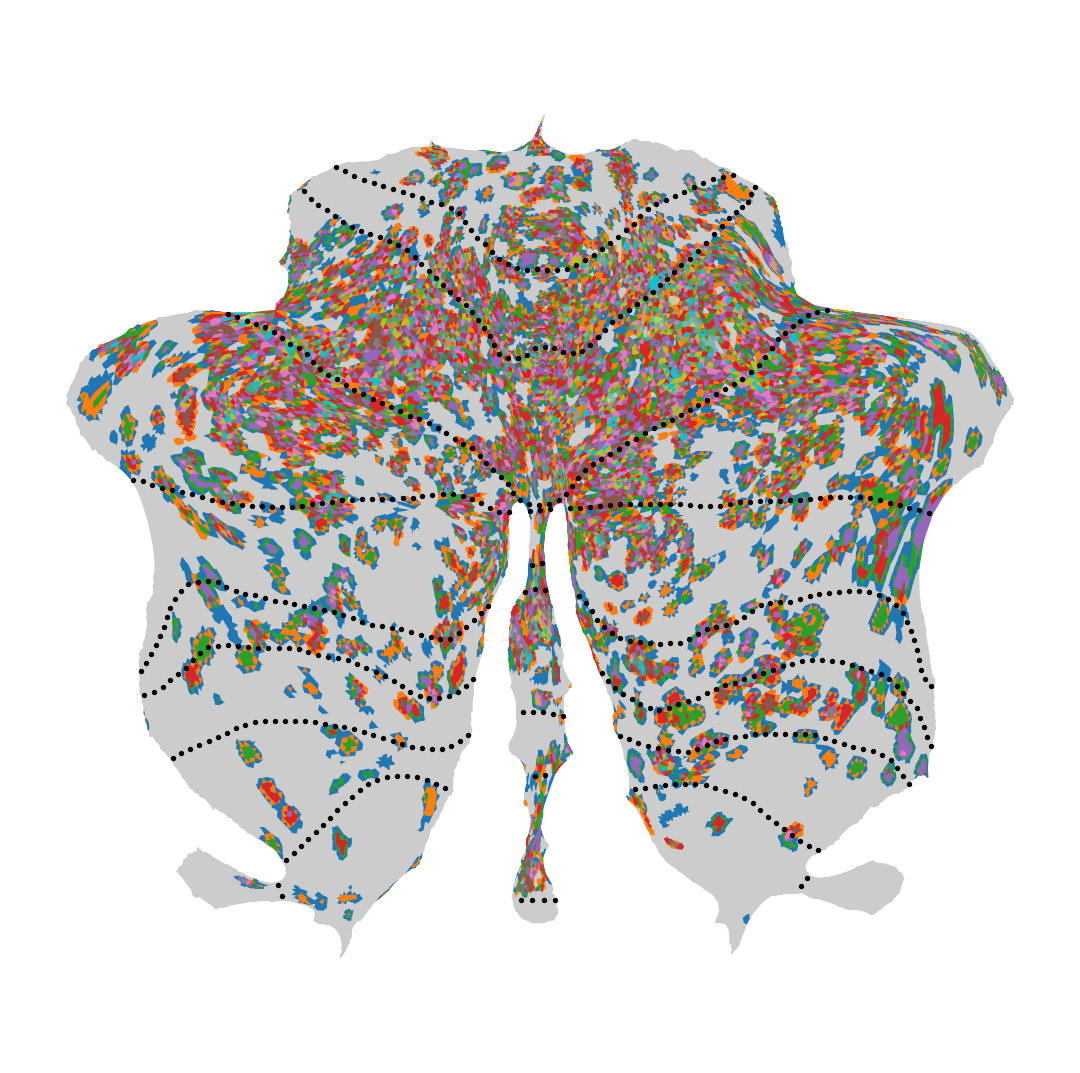

In [11]:
# Define the number of experiments to create a suitable colormap, by combining several qualitative colormaps. 
num_experiments = len(dset.ids)

# Combime several qualitative colormaps.
qualitative_colormaps = [plt.cm.tab20, plt.cm.Set1, plt.cm.Set2, plt.cm.Paired]

# Cycle through them to get a sufficient number of colors
colors = []
for cmap in qualitative_colormaps:
    colors.extend(cmap(np.linspace(0, 1, cmap.N))[::2])

# Truncate the list of colors to the number of experiments, and prepend a grey for background. Notify this is a simplified grey versus the standard SUIT background.
grey_color = (0.8, 0.8, 0.8, 1)  # RGBA for grey
colors = [grey_color] + colors[:num_experiments]  # Prepend grey for background

# Load the MNI template and calculate voxel indices
mni_temp = nilearn.datasets.load_mni152_template(resolution=2) # Resamples the resolution of the map.
foci_img_data = np.zeros(mni_temp.shape)

# Assuming `null_xyz` is grouped by experiment (we made sure of this by combining experiments within a study so that only one experiment remains):
# Split `null_xyz` into chunks corresponding to each experiment
experiment_xyz_list = np.array_split(null_xyz, num_experiments)

# Iterate over each experiment and its corresponding color
for i, experiment_xyz in enumerate(experiment_xyz_list):
    # Convert the experiment's coordinates to voxel indices
    experiment_ijk = nibabel.affines.apply_affine(np.linalg.inv(mni_temp.affine), experiment_xyz).astype('int')
    
    # Set the foci in the image, with a unique value for each experiment
    foci_img_data[experiment_ijk[:, 0], experiment_ijk[:, 1], experiment_ijk[:, 2]] = i + 1

# Create a new image using the foci data
foci_img = nilearn.image.new_img_like(mni_temp, foci_img_data)
foci_img_flat = SUITPy.vol_to_surf(foci_img, space='SPM') # Set space to SPm to corrrectly convert the coordinates to the flatmap.

# Create a colormap with grey as the first color for the background
foci_cmap = ListedColormap(colors)

# Plot the foci image with the custom color mapping that colors each experiment with a seperate color
fig = plt.figure(figsize=(10, 10))
SUITPy.flatmap.plot(foci_img_flat, cmap=foci_cmap)

# Save the figure to a file
output_path = os.path.join(BASE_DIR, 'Figures/Publication/Figure8/8a_WorkingMemory_foci_distribution_flatmap.png')
plt.gcf().savefig(output_path, bbox_inches='tight', transparent=True)

# Close the display
plt.close(fig)


# Let's also plot the distribution of coordinates along the z-axis. 

In [25]:
xyz = dset.coordinates[['x', 'y', 'z']].values

In [9]:
dset.metadata

id  study_id contrast_id sample_sizes             author  year
65  10030050-0  10030050           0         [18]        Mensebach C  2009
66  10030065-0  10030065           0         [10]          Smith Y R  2006
67  10030079-0  10030079           0         [18]         Altamura M  2007
68  10060114-0  10060114           0         [17]    Langenecker S A  2007
69  11080072-0  11080072           0         [20]              Han S  2010
..         ...       ...         ...          ...                ...   ...
60   8100252-0   8100252           0         [14]  Sanchez-Carrion R  2008
61   9090085-0   9090085           0         [20]          Drapier D  2008
62   9090086-0   9090086           0         [18]           Gruber O  2010
63   9090092-0   9090092           0         [12]        Beneventi H  2007
64   9090132-0   9090132           0         [19]       LoPresti M L  2008

[113 rows x 6 columns]

In [26]:
xyz

array([[  5.28859494, -39.01436771, -28.73658088],
       [ 25.        , -75.        , -17.        ],
       [-12.        , -75.        , -14.        ],
       ...,
       [ -6.        , -80.        , -38.        ],
       [ 24.        , -80.        , -14.        ],
       [  0.        , -52.        , -44.        ]])

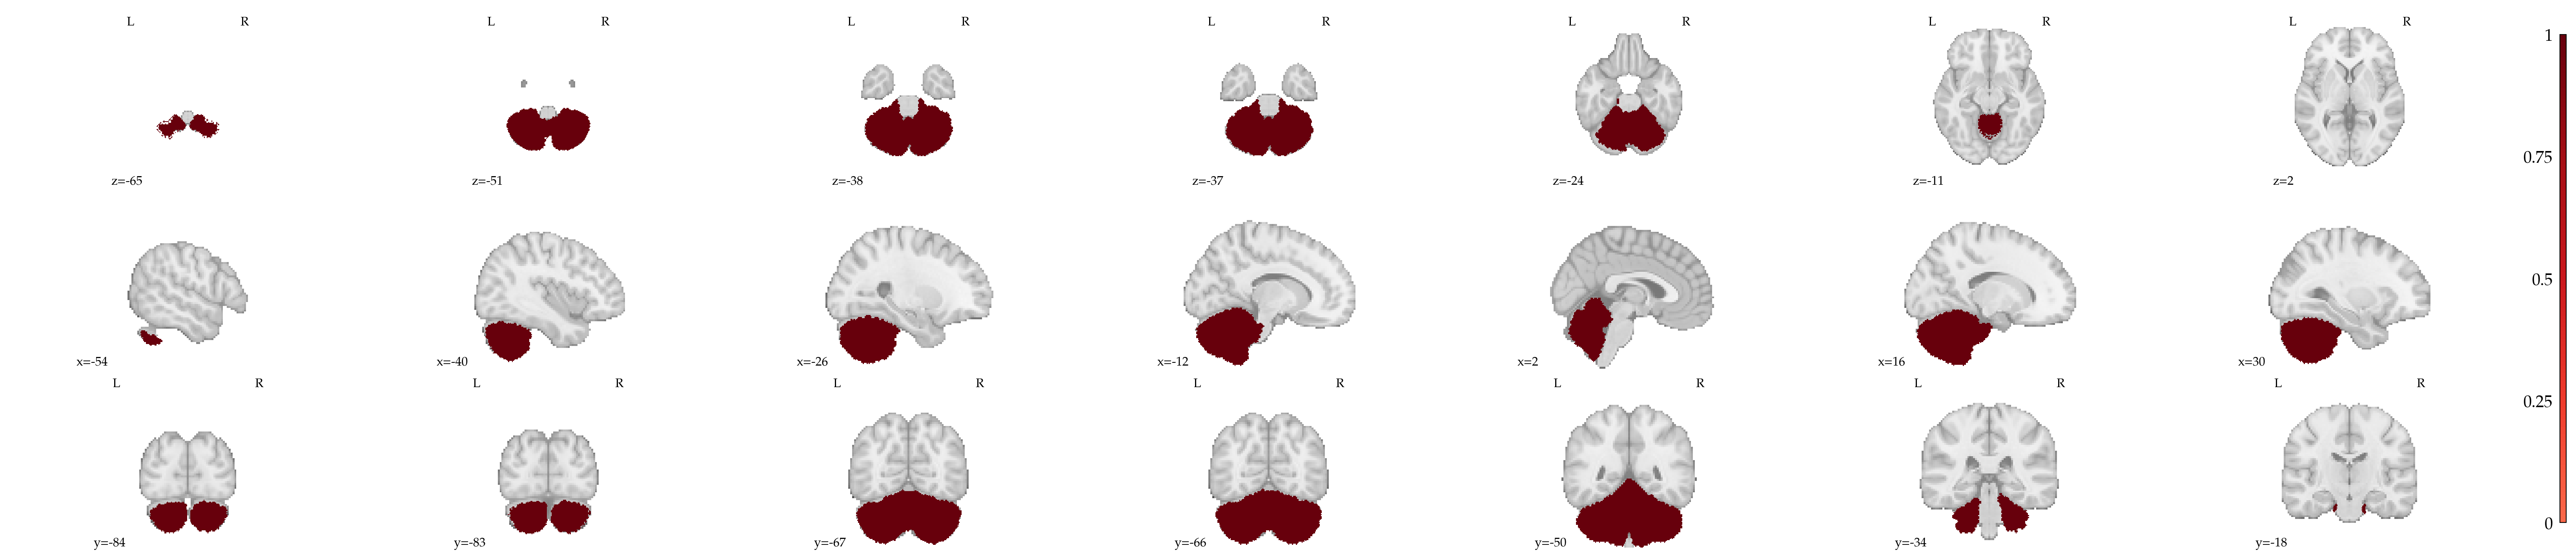

In [27]:
cerebellum_mask_1mm = nibabel.load(os.path.join(INPUT_DIR, 'maps', 'cerebellumMask_1mm.nii.gz'))
cerebellum_mask_1mm_mni = nilearn.image.resample_to_img(cerebellum_mask_1mm, mni_temp, interpolation='nearest')
nilearn.plotting.plot_stat_map(
    cerebellum_mask_1mm_mni, 
    threshold=0, display_mode='mosaic',
    cmap='Reds'
)

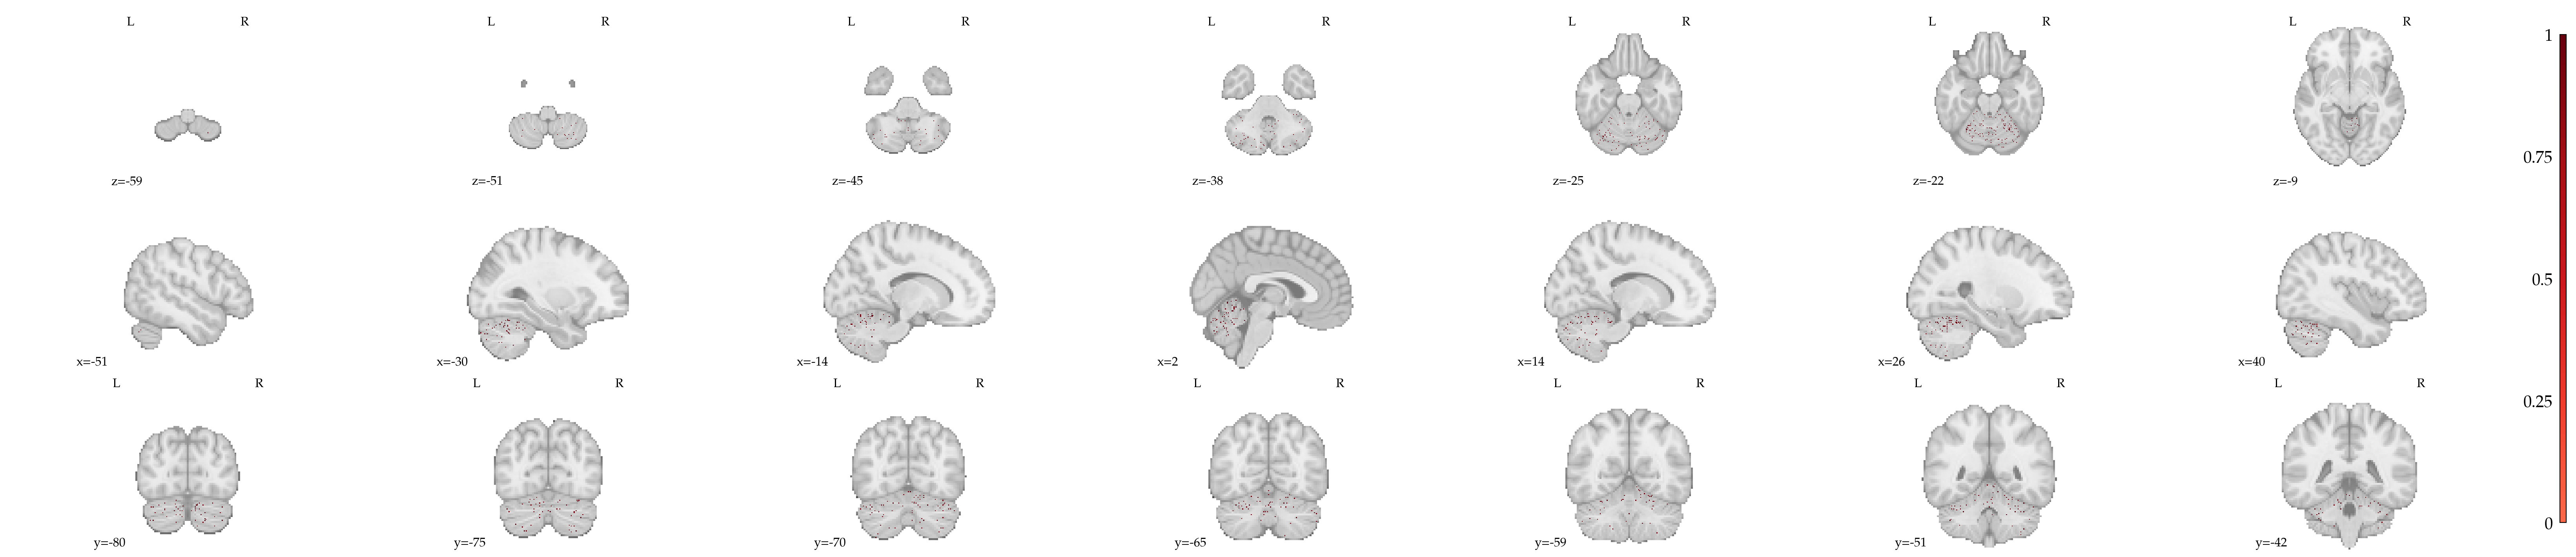

In [28]:
foci_img_data[~(cerebellum_mask_1mm_mni.get_fdata().astype('bool'))] = 0
foci_img = nilearn.image.new_img_like(mni_temp, foci_img_data)
nilearn.plotting.plot_stat_map(
    foci_img, 
    threshold=0, display_mode='mosaic',
    cmap='Reds'
)
# Verify (visually) that coordinates are restricted to the cerebellar ROI!

In [29]:
ijk_cerebellum = np.vstack(np.where(foci_img_data>0)).T
xyz_cerebellum = nibabel.affines.apply_affine(mni_temp.affine, ijk_cerebellum)
print(xyz_cerebellum.shape)
xyz_cerebellum

(2564, 3)


array([[-51., -69., -34.],
       [-51., -67., -32.],
       [-50., -70., -30.],
       ...,
       [ 52., -69., -38.],
       [ 52., -64., -39.],
       [ 52., -50., -42.]])

In [30]:
# get MNI coordinates of all cerebellum voxels (2mm space to reduce computational costs)
cerebellum_mask_2mm = nibabel.load(os.path.join(INPUT_DIR, 'maps', 'cerebellumMask.nii.gz'))
mask_ijk = np.vstack(np.where(cerebellum_mask_2mm.get_fdata() > 0)).T
mask_xyz = nibabel.affines.apply_affine(cerebellum_mask_2mm.affine, mask_ijk)
mask_xyz

array([[ 56., -62., -38.],
       [ 56., -62., -36.],
       [ 56., -60., -40.],
       ...,
       [-54., -48., -42.],
       [-54., -46., -44.],
       [-54., -46., -42.]])

In [31]:
xyz_cerebellum_2 = []
# get points with a min distance of < 2mm from all cerebellar voxels
# not using scipy.spatial.distance_matrix to avoid using a lot of memory
for curr_point in tqdm(xyz): 
    curr_dist = np.linalg.norm(np.array(curr_point)[np.newaxis, :] - mask_xyz, axis=1)
    if curr_dist.min() <= 2:
        xyz_cerebellum_2.append(curr_point)
xyz_cerebellum_2 = np.array(xyz_cerebellum_2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 427/427 [00:00<00:00, 975.30it/s]


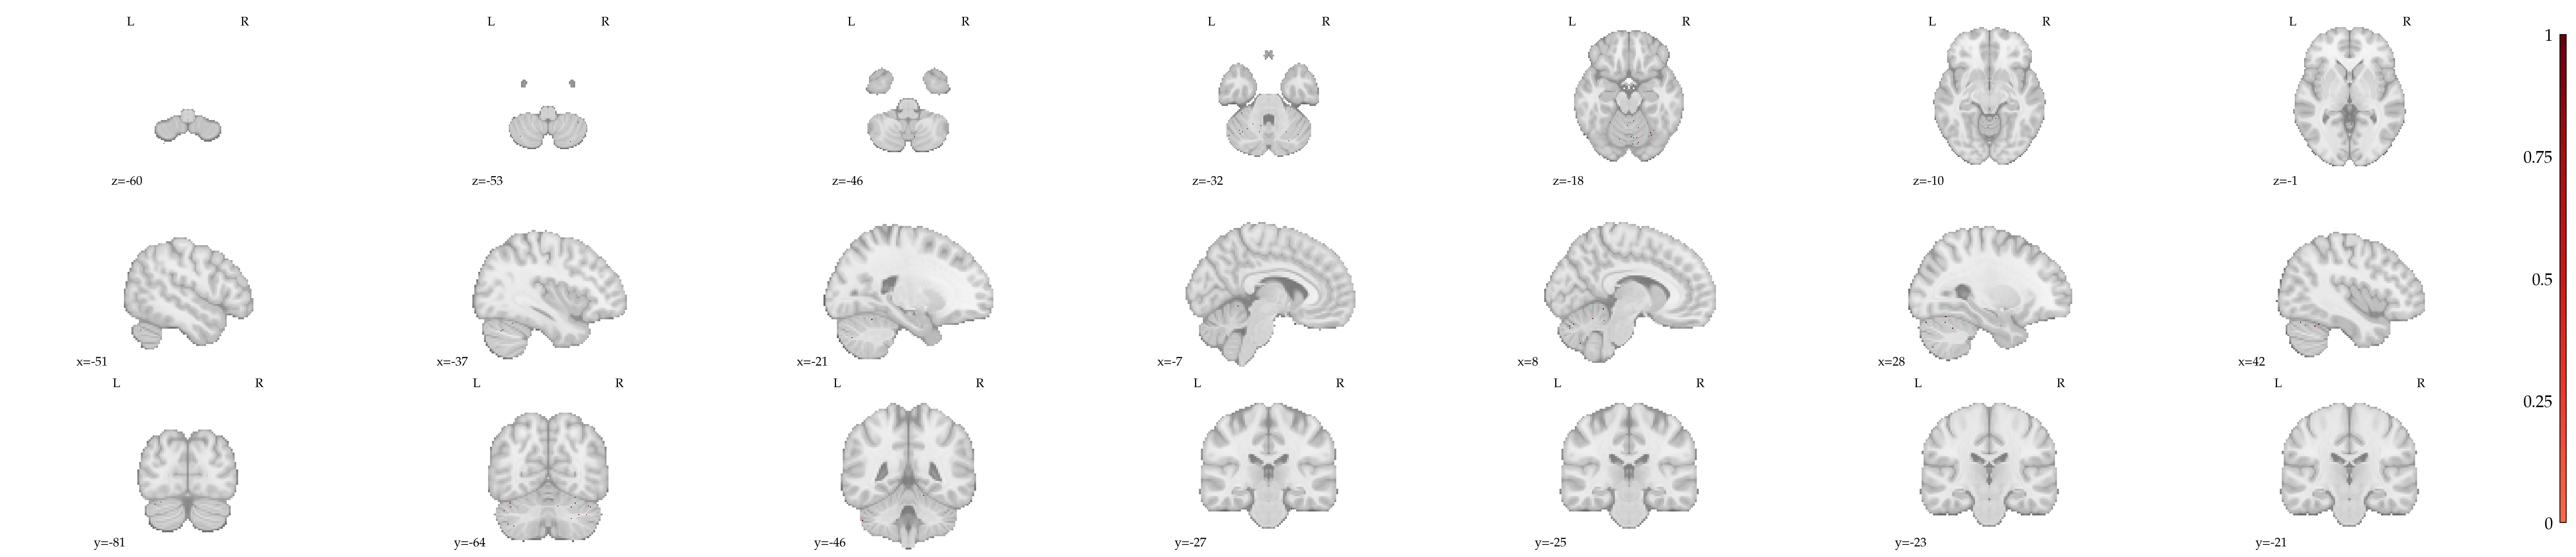

In [32]:
# Check if coordinates were correctly restricted to the cerebellum. This map shows a strong superior bias.
foci_voxels = nibabel.affines.apply_affine(np.linalg.inv(mni_temp.affine), xyz_cerebellum_2).astype('int')
foci_img_data = np.zeros(mni_temp.shape)
foci_img_data[foci_voxels[:,0], foci_voxels[:, 1], foci_voxels[:, 2]] = 1
foci_img = nilearn.image.new_img_like(mni_temp, foci_img_data)
nilearn.plotting.plot_stat_map(
    foci_img, 
    threshold=0, display_mode='mosaic',
    cmap='Reds'
) # Extra-cerebellar coordinates should be gone!

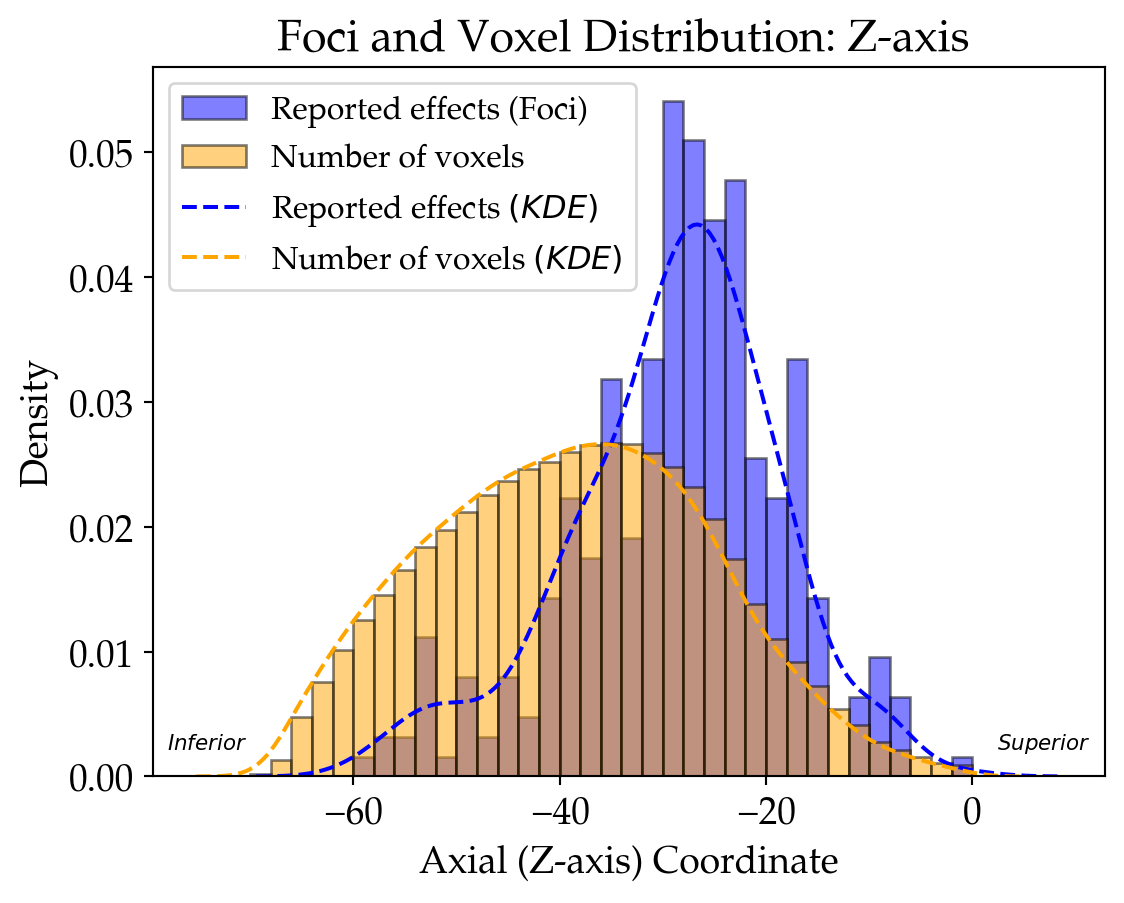

In [33]:
# Set up font style
plt.rcParams["font.family"] = "Asana Math"
plt.rcParams["font.size"] = 14
plt.rcParams["figure.dpi"] = 192

# Determine bins for the histograms based on both foci and voxels
bins = np.histogram_bin_edges(np.concatenate([xyz_cerebellum_2[:, 2], mask_xyz[:, 2]]), bins=35)

# Plot the histogram for the reported effects
plt.hist(xyz_cerebellum_2[:, 2], bins=bins, density=True, alpha=0.5, label='Reported effects (Foci)', color='blue', edgecolor='black')

# Plot the histogram for the number of voxels
plt.hist(mask_xyz[:, 2], bins=bins, density=True, alpha=0.5, label='Number of voxels', color='orange', edgecolor='black')

# Optionally, add KDE for smoothed distribution
sns.kdeplot(xyz_cerebellum_2[:, 2], color='blue', label='Reported effects $\mathit{(KDE)}$', linestyle='--')
sns.kdeplot(mask_xyz[:, 2], color='orange', label='Number of voxels $\mathit{(KDE)}$', linestyle='--')

# Add legend and labels
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(0.0, 1))
plt.xlabel('Axial (Z-axis) Coordinate')
plt.ylabel('Density')
plt.title('Foci and Voxel Distribution: Z-axis ')

# Add manual labels on the bottom left and right corners with offset
x_offset = 0.015 * (plt.xlim()[1] - plt.xlim()[0])
y_offset = 0.03 * (plt.ylim()[1] - plt.ylim()[0])

plt.text(x=plt.xlim()[0] + x_offset, y=plt.ylim()[0] + y_offset, 
         s='$\mathit{Inferior}$', ha='left', va='bottom', fontsize=8)
plt.text(x=plt.xlim()[1] - x_offset, y=plt.ylim()[0] + y_offset, 
         s='$\mathit{Superior}$', ha='right', va='bottom', fontsize=8)

# Save the figure
plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure8/WorkingMemory_Foci_voxel_Distributions_z-axis.png'), bbox_inches='tight')

# Show the plot
plt.show()


# Split foci for the example experiments (for which we also show the MA-maps).

In [13]:
from scipy.ndimage import binary_dilation  # Import for binary dilation

In [16]:
# Define an empty flatmap (all NaNs). This is to ensure visual consistency in case an experiment has no coordinates within the cerebellar mask (note it might still have one in the dilated mask).
empty_map = np.full_like(SUITPy.flatmap.vol_to_surf(mni_temp), np.NaN)

# Create a consistent color for the background
grey_color = (0.8, 0.8, 0.8, 1)  # RGBA for grey
grey_color_map = ListedColormap([grey_color])

# Define the indices (corresponding to the experiment number) of your interest.
indices = [0, 1, len(dset.ids) - 1]

# Iterate over Experiment indices, as well as their colors. In this way we can select what coordinates + ma-maps we want to illustrate for the figure.
for idx, exp_id in enumerate(indices):
    exp_coords = dset.coordinates[dset.coordinates['id'] == dset.ids[exp_id]] # Coordinates are saved in the dset and can be filtered by id.

    # Create a new figure for every experiment seperately.
    fig = plt.figure(figsize=(10, 10))

    # If there are no coordinates, plot an empty grey background
    if exp_coords.shape[0] == 0:  
        # Plot the empty flatmap with the custom grey undermap
        SUITPy.flatmap.plot(empty_map, colorbar=False, new_figure=False, bordersize=0.5, undermap=grey_color_map)
    
    # If there are coordinates, proceed visualising those foci.
    else:
        # Prepare foci image data
        foci_img_data = np.zeros(mni_temp.shape)
        experiment_xyz = exp_coords[['x', 'y', 'z']].values

        experiment_ijk = nibabel.affines.apply_affine(np.linalg.inv(mni_temp.affine), experiment_xyz).astype('int')

        valid_indices = np.all(experiment_ijk >= 0, axis=1) & np.all(experiment_ijk < np.array(mni_temp.shape), axis=1)
        experiment_ijk = experiment_ijk[valid_indices]

        if experiment_ijk.size > 0:  # If valid coordinates are present
            foci_img_data[experiment_ijk[:, 0], experiment_ijk[:, 1], experiment_ijk[:, 2]] = 1
            # Dilate the foci to make them appear larger
            foci_img_data = binary_dilation(foci_img_data, iterations=1)  # Increase iterations to enlarge further
            
            foci_img = nilearn.image.new_img_like(mni_temp, foci_img_data)
            foci_img_flat = SUITPy.flatmap.vol_to_surf(foci_img, space='SPM')

            foci_cmap = ListedColormap([grey_color] + [colors[idx + 1]])

            # Plot the foci image with the color mapping
            SUITPy.flatmap.plot(foci_img_flat, cmap=foci_cmap, colorbar=False, new_figure=False, bordersize=0.5, undermap=grey_color_map)
        else:
            # If no valid coordinates, just plot the grey background
            SUITPy.flatmap.plot(empty_map, colorbar=False, new_figure=False, bordersize=0.5, undermap=grey_color_map)

    # Set the title and save the figure
    # plt.title(f"Experiment {exp_id + 1}", fontsize=20, y=1.0)
    output_path = os.path.join(BASE_DIR, f'Figures/Publication/Figure8/8b_working-memory_foci-exps/WorkingMemory_foci_distribution_experiment_{exp_id + 1}.png')
    plt.savefig(output_path, bbox_inches='tight', transparent=True)
    plt.close(fig)

    print(f"Saved flatmap for Experiment {exp_id + 1} to {output_path}")



/data/project/cerebellum_ale/venv/lib/python3.11/site-packages/SUITPy/flatmap.py:497: RuntimeWarning: invalid value encountered in divide
  data = ((data - cscale[0]) / (cscale[1] - cscale[0]))


Saved flatmap for Experiment 1 to /data/project/cerebellum_ale/Figures/Publication/Figure8/8b_working-memory_foci-exps/WorkingMemory_foci_distribution_experiment_1.png
Saved flatmap for Experiment 2 to /data/project/cerebellum_ale/Figures/Publication/Figure8/8b_working-memory_foci-exps/WorkingMemory_foci_distribution_experiment_2.png
Saved flatmap for Experiment 113 to /data/project/cerebellum_ale/Figures/Publication/Figure8/8b_working-memory_foci-exps/WorkingMemory_foci_distribution_experiment_113.png


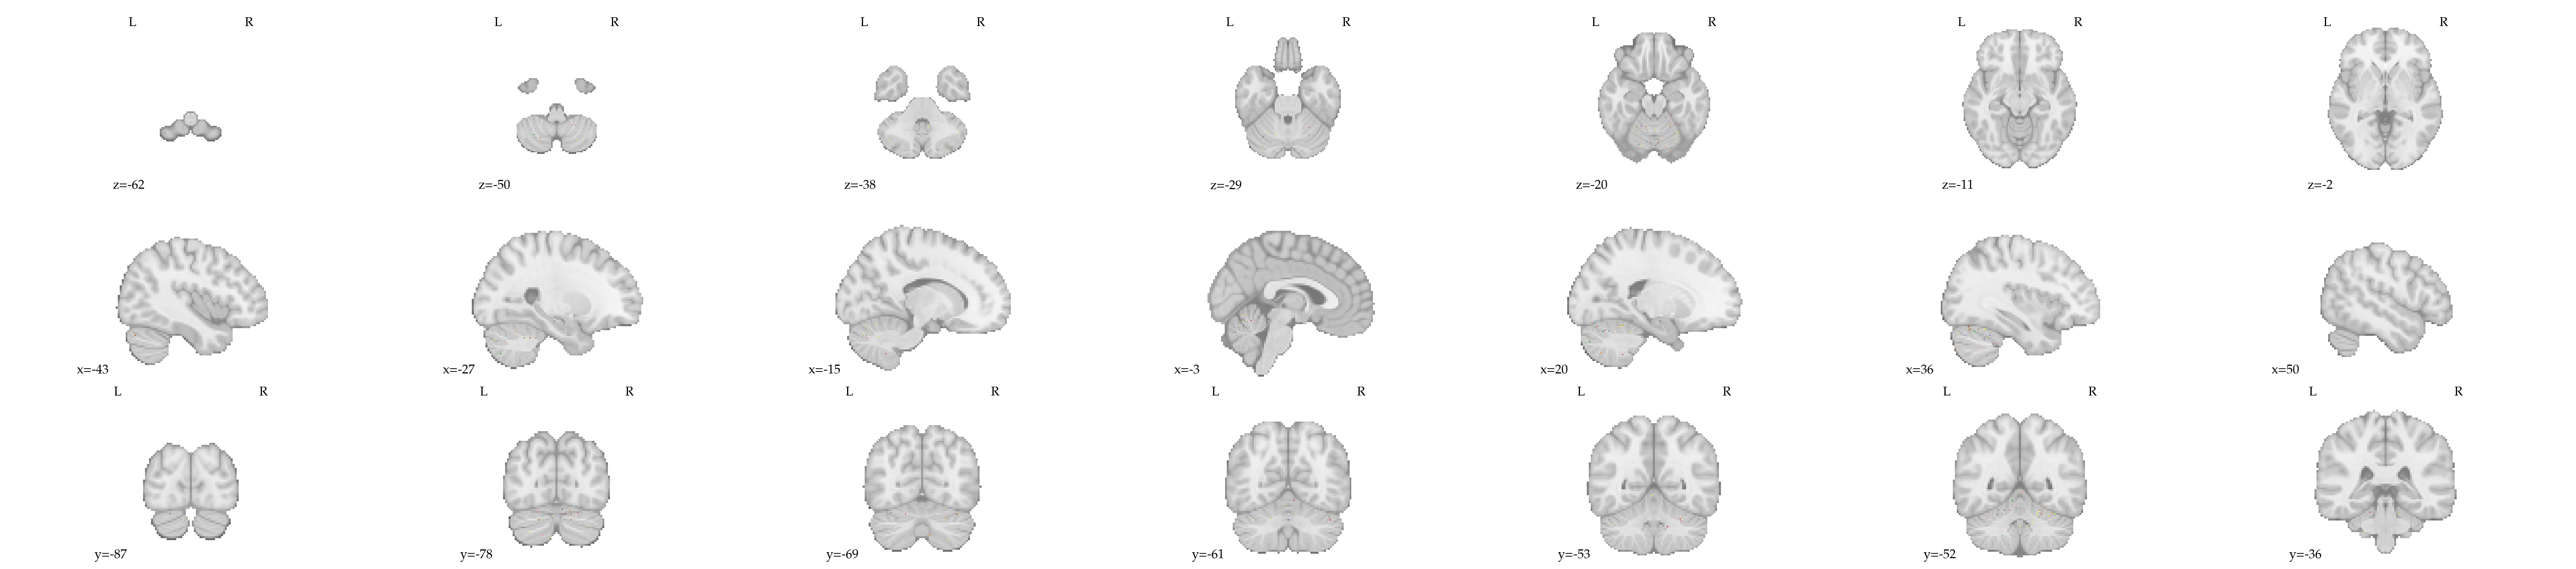

In [13]:
# Assuming `null_xyz` contains coordinates for working memory experiments
num_experiments = len(dset.ids)

# Define a list of qualitative colormaps from which to sample colors
qualitative_colormaps = [plt.cm.tab20, plt.cm.Set1, plt.cm.Set2, plt.cm.Paired]

# Combine the colormaps and cycle through them to get a sufficient number of colors
colors = []
for cmap in qualitative_colormaps:
    colors.extend(cmap(np.linspace(0, 1, cmap.N)))

# If you need more colors than what you have, cycle through the colors list
colors = colors[:num_experiments]  # Truncate to the number of experiments

# Load the MNI template and calculate voxel indices
mni_temp = nilearn.datasets.load_mni152_template(resolution=1)
foci_img_data = np.zeros(mni_temp.shape)

# Assuming `null_xyz` is grouped by experiment:
# Split `null_xyz` into chunks corresponding to each experiment
experiment_xyz_list = np.array_split(null_xyz, num_experiments)

# Iterate over each experiment and its corresponding color
for i, (experiment_xyz, color) in enumerate(zip(experiment_xyz_list, colors)):
    # Convert the experiment's coordinates to voxel indices
    experiment_ijk = nibabel.affines.apply_affine(np.linalg.inv(mni_temp.affine), experiment_xyz).astype('int')
    
    # Set the foci in the image, with a unique value for each experiment
    foci_img_data[experiment_ijk[:, 0], experiment_ijk[:, 1], experiment_ijk[:, 2]] = i + 1

# Create a new image using the foci data
foci_img = nilearn.image.new_img_like(mni_temp, foci_img_data)

# Plot the foci image with the custom color gradient
fig = plt.figure(figsize=(10, 3))

nilearn.plotting.plot_stat_map(
    foci_img, 
    threshold=0, display_mode='mosaic',
    cmap=ListedColormap(colors),
    colorbar=False
)

# Save the figure to a file
output_path = os.path.join(BASE_DIR, 'Figures/Publication/Figure8/WorkingMemory_foci_distribution_mosaic.png')
plt.gcf().savefig(output_path, bbox_inches='tight', transparent=True)

# Close the display to avoid displaying it in interactive environments
plt.close(fig)


# Plot the Working Memory Ma-maps corresponding to the experiment indices.

In [39]:
wm_flatmaps = np.load(os.path.join(BASE_DIR, 'experiments/240913_methods_plot_workingmemory/example_ma_flatmaps.npy'))

In [40]:
wm_flatmaps.shape

(4, 28935)

In [41]:
print(f"Shape of wm_flatmaps: {wm_flatmaps.shape}")
print(f"Type of wm_flatmaps: {type(wm_flatmaps)}")

Shape of wm_flatmaps: (4, 28935)
Type of wm_flatmaps: <class 'numpy.ndarray'>


In [51]:
# Define the base directory where the output should be saved
output_8b = os.path.join(BASE_DIR, 'Figures/Publication/Figure8/8b_working-memory_ma-maps')
os.makedirs(output_8b, exist_ok=True)

# Define the indices corresponding to first, second, third, and last map
map_indices = [0, 1, 2, len(wm_flatmaps) - 1]

for i, ma_idx in enumerate(map_indices):
    # Create a new figure for each flatmap
    fig = plt.figure(figsize=(12, 8))  # Adjust the size as needed
    
    # Plot the flatmap using SUITPy
    SUITPy.flatmap.plot(
        wm_flatmaps[ma_idx],
        colorbar=True,
        new_figure=False,  # Plot on the current figure
        bordersize=0.5,
        bordercolor='white'
    )
    
    # Adjust title position
    title_offset = 1.2
    
    # Set the title for each figure
    title_text = f"N = {113}" if i == len(map_indices) - 1 else f"N = {i + 1}"
    plt.title(title_text, fontsize=40, y=title_offset)
    
    # Define the file path based on the index
    file_name = 'ma_map-113.png' if i == len(map_indices) - 1 else f'ma_map-{i + 1}.png'
    file_path = os.path.join(output_8b, file_name)
    
    # Save the figure to a file
    fig.savefig(file_path, dpi=300, bbox_inches='tight')
    
    # Close the figure to avoid memory issues
    plt.close(fig)
    
    print(f"Saved flatmap {i + 1} to {file_path}")


Saved flatmap 1 to /data/project/cerebellum_ale/Figures/Publication/Figure8/8b_working-memory_ma-maps/ma_map-1.png
Saved flatmap 2 to /data/project/cerebellum_ale/Figures/Publication/Figure8/8b_working-memory_ma-maps/ma_map-2.png
Saved flatmap 3 to /data/project/cerebellum_ale/Figures/Publication/Figure8/8b_working-memory_ma-maps/ma_map-3.png
Saved flatmap 4 to /data/project/cerebellum_ale/Figures/Publication/Figure8/8b_working-memory_ma-maps/ma_map-113.png


# Plot the overal working memory ALE map

In [9]:
wm_flatmap_ale = np.load(os.path.join(BASE_DIR, 'experiments/240913_methods_plot_workingmemory/ale_flatmap.npy')) # Load the ALE flatmap.

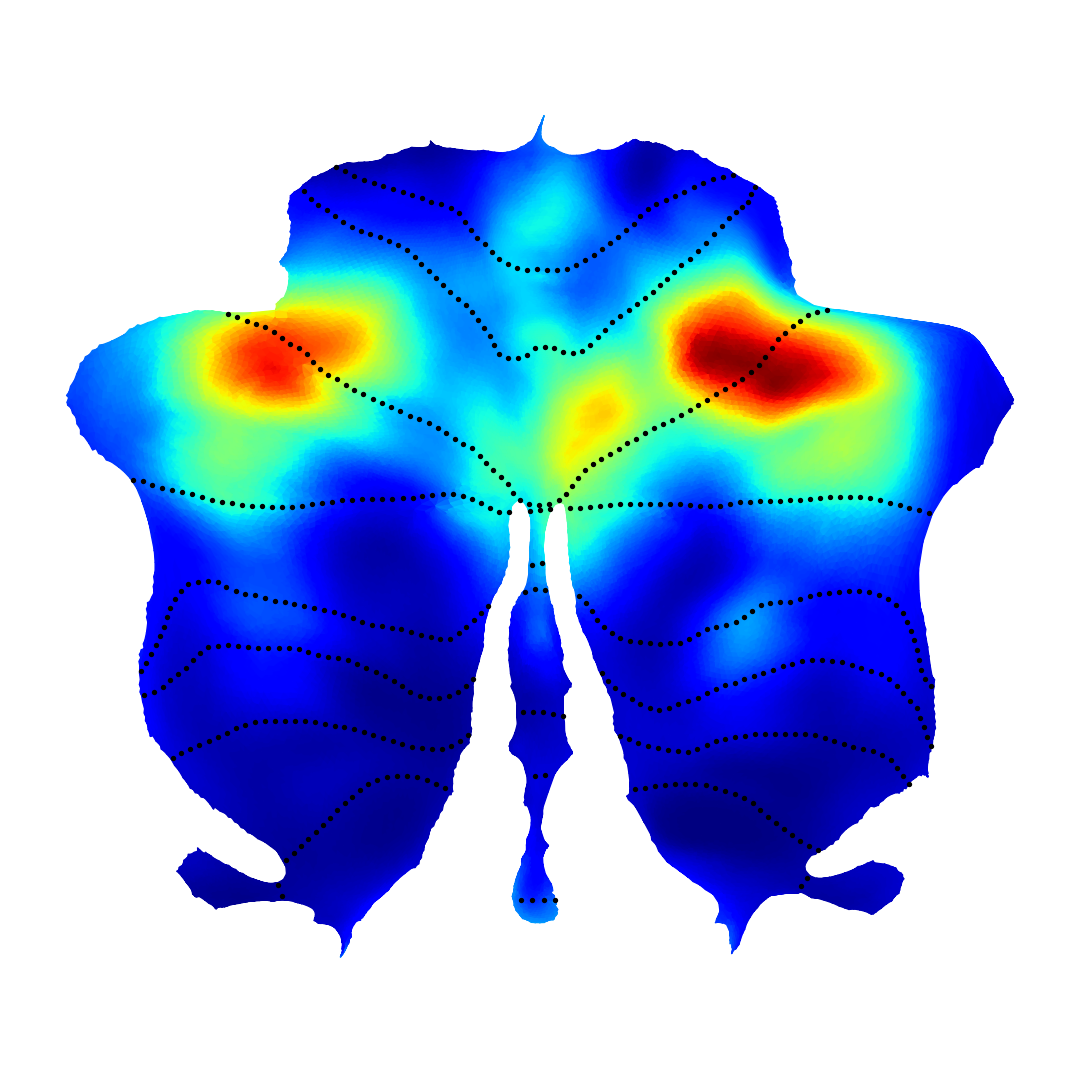

In [10]:
# Create a new figure
fig = plt.figure(figsize=(10, 10))

# Plot the flatmap
SUITPy.flatmap.plot(wm_flatmap_ale)

# Save it
output_path = os.path.join(BASE_DIR, f'Figures/Publication/Figure8/8c_WorkingMemory_ale-score-map.png')
plt.savefig(output_path, bbox_inches='tight', transparent=True)
plt.close(fig)

# Then illustrate a the 1st, 2nd, and nth (n = 10,000) random nulls (for C-SALE)

In [20]:
# Load the example nulls
nulls_flatmap_ale = np.load(os.path.join(BASE_DIR, 'experiments/240913_methods_plot_workingmemory/example_null_flatmaps.npy'))

In [27]:
nulls_flatmap_ale.shape # contains 4 maps
# len(nulls_flatmap_ale)

(4, 28935)

In [34]:
# Define the base directory where the output should be saved
output_8de = os.path.join(BASE_DIR, 'Figures/Publication/Figure8/8de_random-nulls')
os.makedirs(output_8de, exist_ok=True)

# Define the indices corresponding to first, second, third, and last map
null_indices = [0, 1, 2, len(nulls_flatmap_ale) - 1]

for i, ma_idx in enumerate(null_indices):
    # Create a new figure for each flatmap
    fig = plt.figure(figsize=(12, 8))  # Adjust the size as needed
    
    # Plot the flatmap using SUITPy
    SUITPy.flatmap.plot(
        nulls_flatmap_ale[ma_idx],
        colorbar=True,
        new_figure=False,  # Plot on the current figure
        bordersize=0.5,
        bordercolor='white'
    )
    
    # Adjust title position
    title_offset = 1.2
    
    # Set the title for each figure if desired.
    title_text = f"N = {10_000:,}" if i == len(null_indices) - 1 else f"N = {i + 1}"
    # plt.title(title_text, fontsize=40, y=title_offset)
    
    # Define the file path based on the index
    file_name = 'null_map-10000.png' if i == len(null_indices) - 1 else f'null_map-{i + 1}.png'
    file_path = os.path.join(output_8de, file_name)
    
    # Save the figure to a file
    fig.savefig(file_path, dpi=300, bbox_inches='tight')
    
    # Close the figure to avoid memory issues
    plt.close(fig)
    
    print(f"Saved flatmap {i + 1} to {file_path}") # Note that this simply counts, the 4th map is actually the last one.


Saved flatmap 1 to /data/project/cerebellum_ale/Figures/Publication/Figure8/8de_random-nulls/null_map-1.png
Saved flatmap 2 to /data/project/cerebellum_ale/Figures/Publication/Figure8/8de_random-nulls/null_map-2.png
Saved flatmap 3 to /data/project/cerebellum_ale/Figures/Publication/Figure8/8de_random-nulls/null_map-3.png
Saved flatmap 4 to /data/project/cerebellum_ale/Figures/Publication/Figure8/8de_random-nulls/null_map-10000.png


# Show the null hsitograms, for ALE (one common, combined histogram) and C-SALE (one per voxel)

NameError: name 'sale_res' is not defined

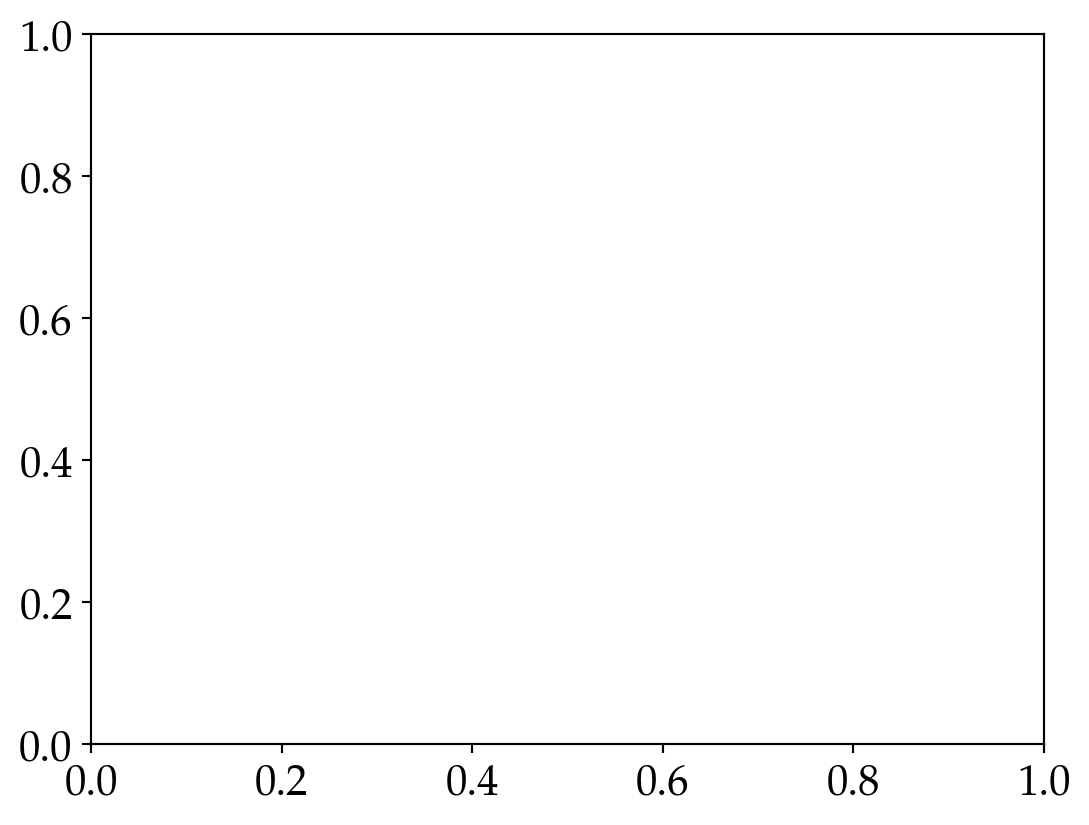

In [36]:
from nimare_gpu.stats import nullhist_to_p  # Assuming this function is available
from nilearn.masking import apply_mask  # Assuming `mask` is a nilearn masker object

# Load the saved histogram and bins data
psale_bins = np.load(os.path.join(BASE_DIR, 'experiments/240913_methods_plot_workingmemory/sale_histogram_bins.npy'))
voxel_hists = np.load(os.path.join(BASE_DIR, 'experiments/240913_methods_plot_workingmemory/sale_voxel_hists.npy'))

# Normalize the histograms
voxel_hists_norm = voxel_hists / voxel_hists.sum(axis=1, keepdims=True)

# Set up the proper mask and flattened version
proper_mask = nibabel.load(f'{INPUT_DIR}/maps/D2009_MNI.nii.gz')
proper_mask_flat = apply_mask(proper_mask, proper_mask).squeeze()  # Assuming mask is applied with nilearn's apply_mask
proper_mask_flat /= proper_mask_flat.sum()

# Create plot
fig, ax = plt.subplots()
np.random.seed(4)  # For reproducibility

# Define voxels (random sampling based on mask and statistics)
voxels = {
    'Random': np.random.choice(np.arange(proper_mask_flat.size), p=proper_mask_flat),
    'Random 2': np.random.choice(np.arange(proper_mask_flat.size), p=proper_mask_flat),
    # Replace 'sale_res.maps' by directly using stat and logp from the appropriate data source
    'Max stat': (sale_res.maps['stat'] * proper_mask_flat).argmax(),
}

# Color palette for the voxels
colors = sns.color_palette('Set1', len(voxels))

# Plot histogram for each voxel
for i, (label, vox) in enumerate(voxels.items()):
    hist = voxel_hists_norm[vox]  # Get the normalized histogram for the voxel
    ax.fill_between(psale_bins, hist, y2=0, where=hist > 0, facecolor=colors[i], edgecolor='none', alpha=0.2, label=label)

# Annotate with p-values
for i, (label, vox) in enumerate(voxels.items()):
    hist = voxel_hists_norm[vox]
    # Calculate p-value from the stat map (assuming 'stat' and 'logp' data available from 'sale_res')
    p = nullhist_to_p(sale_res.maps['stat'][vox], hist, psale_bins)
    if p < 0.001:
        p_text = f'p = {p:.0e}'
    else:
        p_text = f'p = {p:.3f}'
    hist_step = psale_bins[1] - psale_bins[0]
    ax.annotate(p_text, xy=(sale_res.maps['stat'][vox] + hist_step, ax.get_ylim()[1] * 0.75), fontsize=8, rotation=-90)
    ax.axvline(sale_res.maps['stat'][vox], color=colors[i], alpha=0.8)

# Set y-limit and x-limit
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlim([-0.001, 0.025])

# Show plot
plt.show()

# Then, we combine them (union) into one common ALE-score map for all Working Memory experiments. Note that we have not compared this map agains the null-hypoteses yet, and hence aal steps so far are the same for both methods.

# Next, we visualize the null hypothesis of both methods, which is where they start to diverge.

In [29]:
# Read the probabilist space image.
nii_file_path = os.path.join(OUTPUT_DIR, 'BrainMap_dump_Feb2024_kernels_sum.nii.gz')
prob_perm_img = nibabel.load(nii_file_path)

# Access the image data (as a NumPy array)
prob_perm = prob_perm_img.get_fdata()

In [26]:
cerebellum_mask = nibabel.load(os.path.join(INPUT_DIR, 'maps/D2009_MNI.nii.gz'))
cerebellum_mask_dilated =  nibabel.load(os.path.join(INPUT_DIR, 'maps/D2009_MNI_dilated-6mm.nii.gz')) # We dilated the cerebellar mask 6mm in each direction to allow for effects slightly out of the mask (accounting for missalignments).

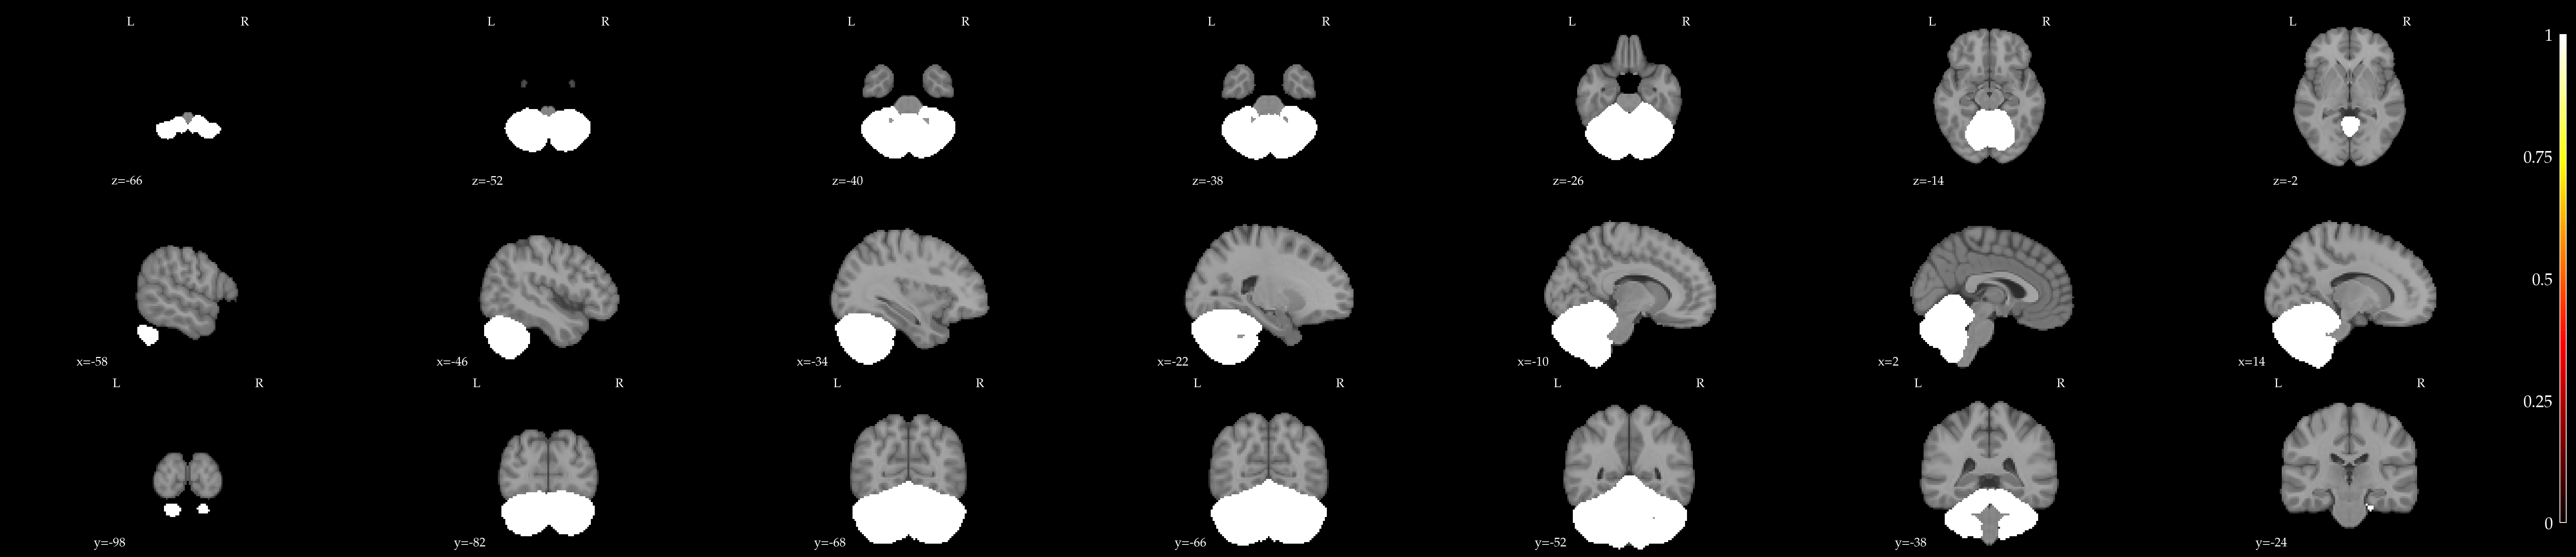

In [27]:
# Resample the mask to the probability map
cerebellum_mask_resampled = nilearn.image.resample_to_img(cerebellum_mask_dilated, prob_perm_img, interpolation='nearest')

# just to make sure resampling was done correctly. Check if the cerebellum is nicely covered by the mask.
nilearn.plotting.plot_stat_map(cerebellum_mask_resampled, display_mode='mosaic', black_bg=True)

In [30]:
prob_perm_masked = prob_perm[cerebellum_mask_resampled.get_fdata().astype(bool)] # get data from within the masked area

In [31]:
sampling_prob = prob_perm_masked / prob_perm_masked.sum() # normalizes to one within the mask. Ultimately will not change the results, but gives a nice probability distribution of finding a focus at any cerebellar voxel.

In [32]:
masker = nilearn.maskers.NiftiMasker(cerebellum_mask_resampled)
masker.fit()

NiftiMasker(mask_img=<nibabel.nifti1.Nifti1Image object at 0x146c3d306b90>)

In [33]:
sampling_prob_img = masker.inverse_transform(sampling_prob) # Recalculate the probabilistic image within the masker only.

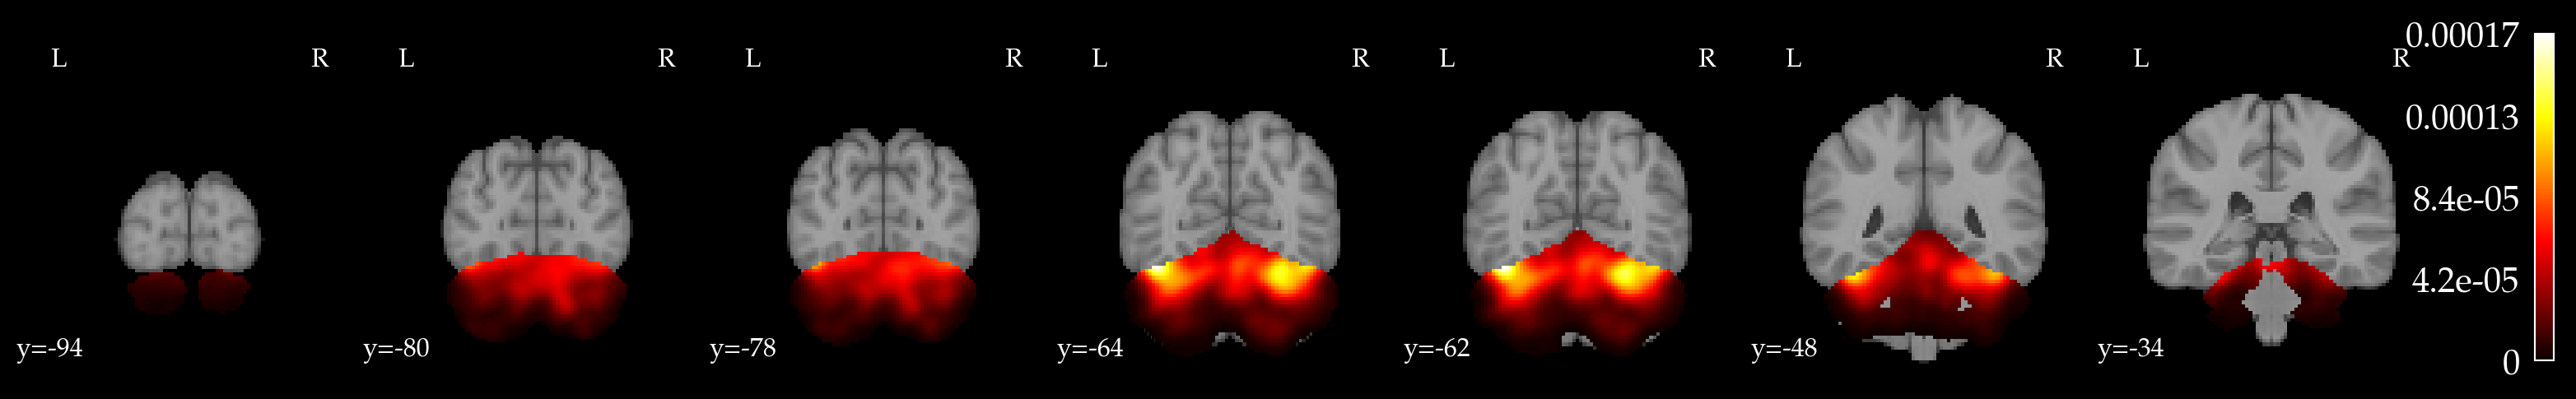

In [34]:
nilearn.plotting.plot_stat_map(sampling_prob_img, display_mode='y', black_bg=True)

In [ ]:
For cerebellum-specific ALE, we simply plot this space onto the cerebellar flatmap.

INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) when text.usetex is True. serif will be used by default.
INFO:matplotlib.texmanager:font.family must be one of (serif, sans-serif, cursive, monospace) 

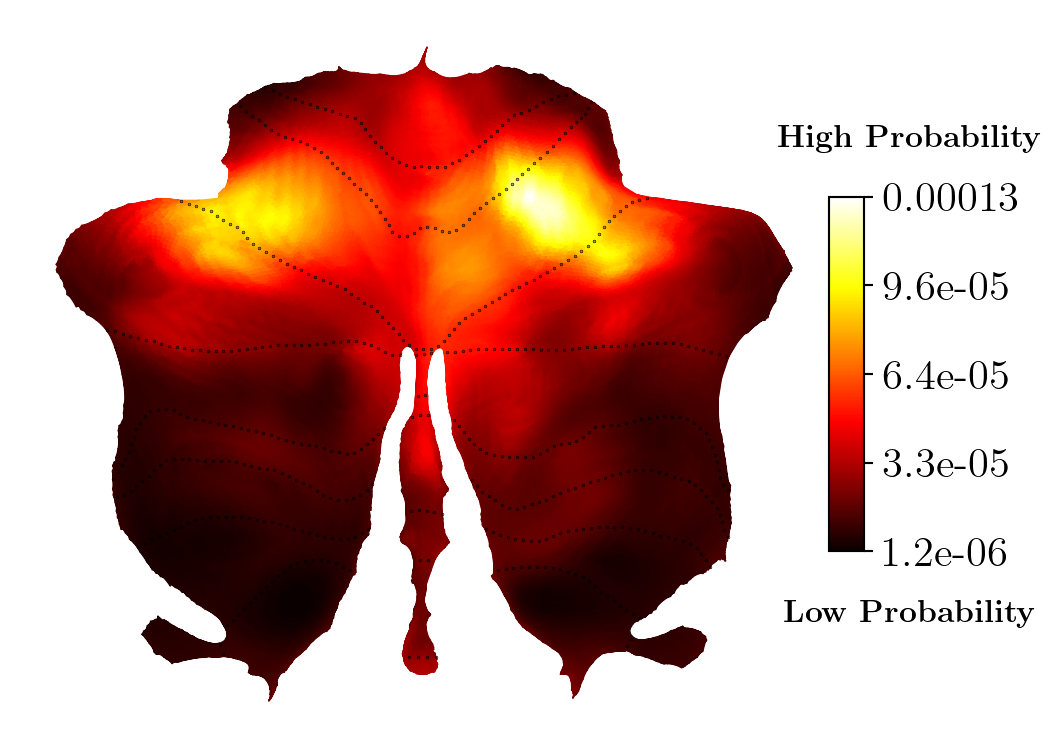

In [36]:
sampling_prob_surf = SUITPy.flatmap.vol_to_surf(sampling_prob_img, space = 'SPM').squeeze()
SUITPy.flatmap.plot(sampling_prob_surf, colorbar=True, new_figure=False, bordersize=0.5, cmap='hot')

# Get the current figure and axis
fig = plt.gcf()
ax = plt.gca()

# Add text labels to the figure with LaTeX formatting for bold text
plt.rcParams['text.usetex'] = True
## Note that it may not always be desirable to enablt LaTex in matplotilib plotting. Disable it after if you wish.

fig.text(0.85, 0.235, r'$\textbf{Low Probability}$', va='center', ha='center', fontsize=12)
fig.text(0.85, 0.75, r'$\textbf{High Probability}$', va='center', ha='center', fontsize=12)

# Save the current figure to a file
plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure8/8b_cerebellar_probabilistic-space.png'))

# Show the plot
plt.show()


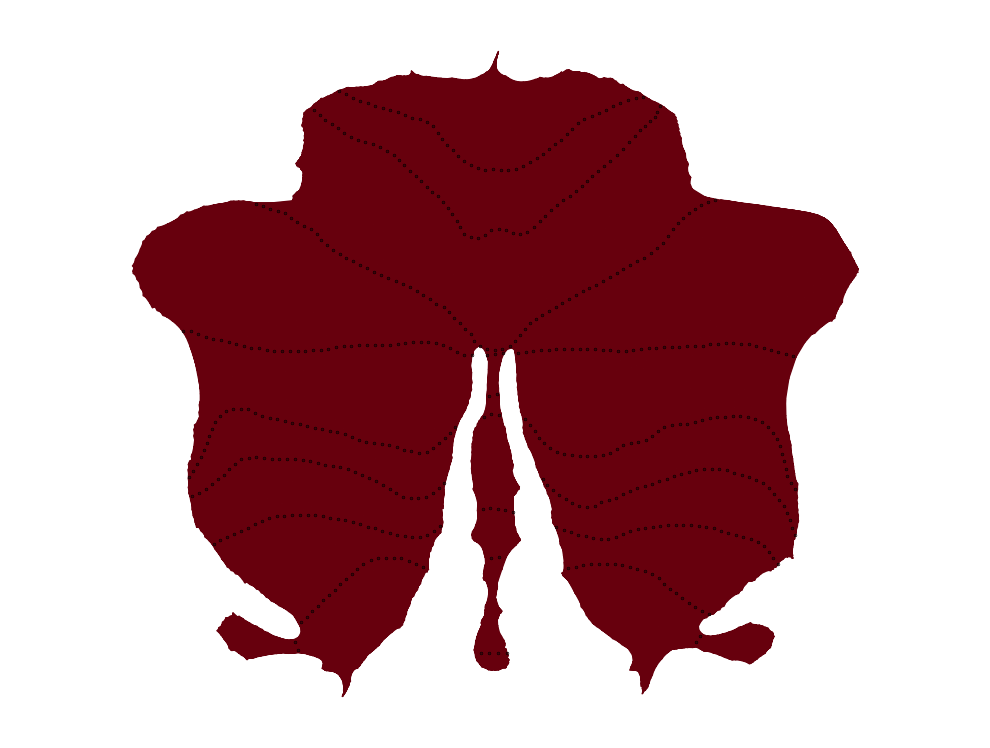

In [39]:
# Disable LaTex
plt.rcParams['text.usetex'] = False

# Hacky workaround to make a flat-colored cerebellar cerebellar flatmap.
# Extract the top color from the 'Reds' colormap
top_color = plt.cm.Reds(1.0)

# Create a custom colormap with the top color on both ends
cmap = mcolors.LinearSegmentedColormap.from_list('custom_reds', [top_color, top_color], N=256)

# Generate the map of a constant value (e.g., 0.5)
sampling_prob_surf = np.full_like(SUITPy.flatmap.vol_to_surf(sampling_prob_img).squeeze(), 0.99)

# Choose a random index and assign it the value 0.98
random_index = np.unravel_index(np.random.choice(sampling_prob_surf.size), sampling_prob_surf.shape)
sampling_prob_surf[random_index] = 0.98

# Plot the flatmap using the custom colormap
SUITPy.flatmap.plot(sampling_prob_surf, colorbar=False, new_figure=False, bordersize=0.5, cmap=cmap)

# Get the current figure and axis
fig = plt.gcf()
ax = plt.gca()

# Save the current figure to a file
plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure8/8b_regularALE.png'))

# Show the plot
plt.show()

# Visualize the 1st, 2nd, and nth random null for both methods

In [ ]:
# Visualize the common ALE-score histogram (Classic ALE) and the 1st, 2nd, and Nth (N = Nvoxels) hisograms for C-SALE.